# Modelo de Vasicek

## Técnicas de Simulación: Trabajo Final

#### Elaborado por:
#### Carlos Iván Santillán Téllez

## Bloque inicial:

In [1]:
import numpy as np                  # Vectores
import pandas as pd                 # DataFrames
import matplotlib.pyplot as plt     # Gráficas
import math                         # Operaciones
import seaborn as sns               # Gráficos y controles de Scrapping
import random                       # Muestreos aleatorios
import time
import PIL                          # Para manipular imágenes

from pylab import plot, title, xlabel, ylabel, show

## Descripción del modelo

Para la simulación nos basaremos en la solución de tipo **Euler - Maruyama** para el 
modelo de Vasicek, lo cual es:

$$r_{dt} = r_{t} + \lambda(\mu - r_{t})dt + \sigma \sqrt{dt} W_{t}$$

En este modelo, los parámetros explican lo siguiente:

- $\lambda$ controla la velocidad de reversión a la media

- $\mu$ es la media de largo plazo, al rededor de la cual sucede la reversión

- $\sigma$ es la volatilidad

## Modelo de Vasicek aplicado al CETE

Tomamos datos históricos del CETE desde el 4 de enero del 2018 hasta el 
14 de noviembre del 2019:

In [2]:
datos_CETE_28 = pd.read_csv("C:/Users/PC/Desktop/ULSA/7 Semestre/Simulacion/CETE_28.csv")
datos_CETE_28.head()

,Fecha,Tasa
0,04/01/2018,7.25
1,11/01/2018,7.24
2,18/01/2018,7.24
3,25/01/2018,7.25
4,01/02/2018,7.24


Últimos registros:

In [3]:
datos_CETE_28.tail()

,Fecha,Tasa
93,17/10/2019,7.67
94,24/10/2019,7.65
95,31/10/2019,7.62
96,07/11/2019,7.55
97,14/11/2019,7.45


Nos quedamos con un vector de tasas:

In [5]:
vector_Tasas_28 = datos_CETE_28['Tasa'].values

### Calibración de parámetros

Usando Máxima Verosimilitud, podemos calibrar nuestros parámetros de la 
siguiente manera:

Sabemos que la función de densidad de la distribución Normal es:
$$f(x)_{X} = \frac{1}{\sqrt{2\pi}} e^{\frac{-1}{2} x^{2}}$$

De modo que la probabilidad condicional de observar $S_{i+1}$ dado que se 
observó $S_{i}$, para un intervalo de tiempo $t$ estará dada por:

$$f(S_{i+1} | S_{i}) = \frac{1}{\sqrt{2\pi \sigma^{2}}} e^{-\frac{(S_{i} - S_{i-1} e^{-\lambda t} -\mu(1 - e^{-\lambda t}))^{2}}{2 \sigma^{2}}}$$

Podemos entonces encontrar la función de Log-verosimilitud:

$$L(\mu, \lambda, \sigma) = \Pi^{n}_{i = 1} f(S_{i})$$

$$= -\frac{n}{2} ln(2\pi) - nln(\sigma) - \frac{1}{2 \sigma^{2}} \Sigma^{n}_{i=1} (S_{i} - S_{i-1} e^{-\lambda t} -\mu(1 - e^{-\lambda t}))^{2}$$

Así pues, derivando e igualando a cero encontramos estimadores para los parámetros

- Estimador para $\mu$

$$\frac{\partial L}{\partial \mu} = \frac{1}{\sigma^{2}} \Sigma{n}_{i=1} S_{i} - S_{i-1} e^{-\lambda t} -\mu(1 - e^{-\lambda t}$$

$$\mu = \frac{\Sigma^{n}_{i=!} S_{i} - S_{i-1} e^{-\lambda t}}{n(1 - e^{-\lambda t})}$$

- Estimador para $\lambda$

$$\frac{\partial L}{\partial \lambda} = -\frac{t e^{-\lambda t}}{\sigma^{2}} \Sigma^{n}_{i=1} (S_{i}-\mu)(S_{i-1}- \mu) - e^{-\lambda t}(S_{i-1} - \mu)^{2}$$

$$\lambda = -\frac{1}{t} ln(\frac{\Sigma^{n}_{i=1} (S_{i}-\mu)(S_{i-1}-\mu)}{\Sigma^{n}_{i=1}(S_{i-1}-\mu)^{2}})$$

- Estimador para $\sigma$

$$\frac{\partial L}{\partial \sigma} = \frac{n}{\sigma} - \frac{1}{\sigma^{3}} \Sigma^{n}_{i=1} (S_{i} - \mu - e^{-\lambda t} (S_{i-1}- \mu))^{2}$$

$$\hat{\sigma^{2}} = \frac{1}{n} \Sigma^{n}_{i=1} (S_{i} - \mu - e^{-\lambda t} (S_{i-1}- \mu))^{2} $$



Para poder llegar a expresiones más fáciles de programar, hacemos los siguientes 
cambios de variable:

- $S_{x} = \Sigma^{n}_{i=1} S_{i-1}$

- $S_{y} = \Sigma^{n}_{i=1} S_{i}$

- $S_{xx} = \Sigma^{n}_{i=1} S_{i-1}^{2}$

- $S_{yy} = \Sigma^{n}_{i=1} S_{i}^{2}$

- $S_{xy} = \Sigma^{n}_{i=1} S_{i} S_{i-1}$

Ya podemos re-expresar a nuestros parámetros como:

$$ \mu = \frac{S_{y} S_{xx} - S_{x} S_{xy}}{n(S_{xx} - S_{xy}) - (S_{x}^{2} - S_{x} S_{y})}$$

$$\lambda = -\frac{1}{t} ln(\frac{S_{xy} - \mu S_{x} - \mu S_{y} -n \mu^{2}}{S_{xx} - 2\mu S_{x} + n \mu^{2}}) $$

$$\hat{\sigma^{2}} = \frac{1}{n} (S_{yy} - 2\alpha S_{xy} + \alpha^{2} S_{xx} - 2\mu (1 - \alpha) (S_{y} - \alpha S_{x}) + n \mu^{2} (1 - \alpha)^{2})$$ 

donde $\alpha = e^{-\lambda t}$ y así:

$$\sigma^{2} = \hat{\sigma^{2}} \frac{2 \lambda}{1 - \alpha^{2}} $$

### Función para calibración de parámetros

In [7]:
### INICIA FUNCIÓN ###
def calibra_parametros(vector_tasas):
    """
    Función que realiza calibración de parámetros para media de largo plazo,
    velocidad de reversión y volatilidad
    :param vector_tasas: numpy array con tasas
    :return: vector_parametros = [mu, lambdaParam, sigma1]
    """
    T = len(vector_tasas)             ### Tiempo total
    m = 1                             ### Tamaño de intervalo de tiempo
    n = len(vector_tasas) - 1       
    a = np.delete(vector_tasas, -1)   ### vector de tasas sin última entrada
    b = np.delete(vector_tasas, 0)    ### vector de tasas sin primera entrada
    producto_ab = a * b               ### producto vectorial 
    
    ### COntruimos factores para facilitar cálculo
    Sx = np.sum(a)
    Sy = np.sum(b)
    Sxx = np.sum(np.square(a))
    Syy = np.sum(np.square(b))
    Sxy = np.sum(producto_ab)
    
    ### Calculamos parámetros por Máxima Verosimilitud
    mu = ((Sy * Sxx) - (Sx * Sxy)) / (n * (Sxx - Sxy) - (Sx**2 - (Sx * Sy)))
    
    lambdaParam = ((Sxy - (mu * Sx) - (mu * Sy) + (n * mu**2))) /(Sxx - (2 * mu * Sx) + (n * mu**2)) / m

    alfa = 1 - lambdaParam * m

    sigmah2 = (Syy - 2*alfa*Sxy + (alfa**2)*Sxx - 2*mu*(1 - alfa)*(Sy - alfa*Sx) + n*(mu**2)*((1-alfa)**2)) / n

    sigma1 = np.sqrt(sigmah2*2*lambdaParam / (1-alfa**2))
    
    vector_parametros = np.asarray([mu, lambdaParam, sigma1])
    
    return vector_parametros
### FIN DE LA FUNCIÓN ###

Calibramos usando los datos del CETE:

In [29]:
parametros = calibra_parametros(vector_Tasas_28)
parametros

array([7.79558611, 0.92570173, 0.32519426])

### Simulación usando diferentes valores de media de largo plazo

Datos iniciales

In [101]:
r0 = vector_Tasas_28[-1]                ### Punto de inicio última cotización de la tasa
media = parametros[0]                   ### Primer entrada del vector de parámetros
velocidad_Reversion = parametros[1]*2     ### Segunda entrada del vector de parámetros
sigma = parametros[2]                   ### Tercera entrada del vector de parámetros

n = 10                     ### Número de Simulciones
T = len(vector_Tasas_28)   ### tiempo total (24
m = 91                     ### subintervalos (100)
dt = T / m                 ### diferencia en tiempo para cada subintervalo

Simulación:

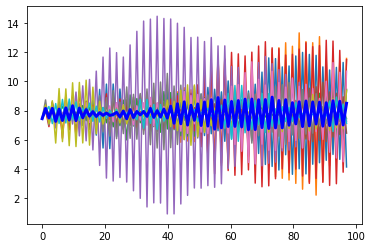

In [102]:
r = np.zeros(shape=(n, m), dtype=float)     ### Matriz con las trayectorias
medias = np.zeros(m)

for j in range(0, n):
    r[j,0] = r0
    for i in range(1, m):
        r[j,i] = r[j,i-1] + velocidad_Reversion * (media - r[j,i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0,1)
        medias[i] = np.mean(r[:,i])
        
    plot(np.arange(0, T, dt), r[j])

medias[0] = r0
plot(np.arange(0, T, dt), medias, 'b', linewidth=3)


Graficamos las trayectorias:

(50,)
(10, 50)


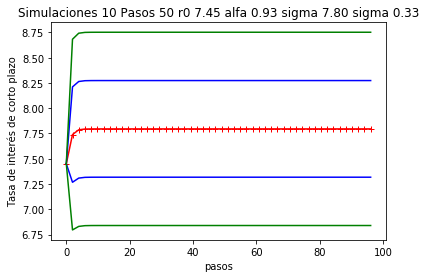

In [59]:
t = np.arange(0, T, dt)
rT_esperado = media + (r0 - media) * (np.exp(-velocidad_Reversion * t))
rT_desviacion = np.sqrt((sigma**2) / (2*velocidad_Reversion) * (1 - (np.exp(-2*velocidad_Reversion*t))))
#print('Esperado: ' + str(rT_esperado))
#print("Desviación: " + str(rT_desviacion))

plot(t, rT_esperado, '-+r')
plot(t, rT_esperado + 2 * rT_desviacion, '-b')
plot(t, rT_esperado - 2 * rT_desviacion, '-b')
plot(t, rT_esperado + 4 * rT_desviacion, '-g')
plot(t, rT_esperado - 4 * rT_desviacion, '-g')

print(t.shape)
print(r.shape)

title('Simulaciones %d Pasos %d r0 %.2f alfa %.2f sigma %.2f sigma %.2f' % (int(n), int(m), r0, velocidad_Reversion, media, sigma))
xlabel('pasos')
ylabel('Tasa de interés de corto plazo')
show()

### Modelo de Vasicek (Función)

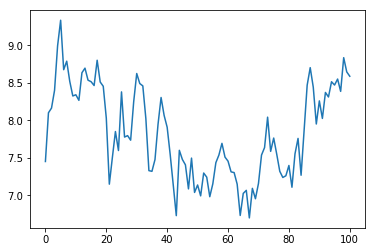

In [61]:
#
import numpy as np

def vasicek(r0, K, theta, sigma, T=1., N=10, seed=0):    
    np.random.seed(seed)
    dt = T/float(N)    
    rendimientos = [r0]
    for i in range(N):
        dr = K*(theta-rendimientos[-1])*dt + sigma*np.random.normal(0, 1)
        rendimientos.append(rendimientos[-1] + dr)
    return range(N+1), rendimientos

if __name__ == "__main__":
    #x, y = vasicek(0.01875, 0.20, 0.01, 0.012, 10., 200)
    #x, y = vasicek(0.075, 0.3, 0.1, 0.03, 24., 100)
    x, y = vasicek(r0, velocidad_Reversion, media, sigma, 24., 100)
    import matplotlib.pyplot as plt
    plt.plot(x,y)
    plt.show()